### Importing Libraries

In [20]:
import math
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

## Visualizing Our Mini PyTorch Computation Graph

In this mini PyTorch project, I've built a simple tool to visualize the computation graphs that form during tensor operations. This helps illustrate how tensors interact and how gradients flow during backpropagation.

### `trace(root)`
- **Purpose:**  
  Recursively collects all tensors (nodes) and their relationships (edges) starting from a given root tensor.
  
- **How It Works:**  
  It follows the chain of parent tensors (i.e., the tensors used to create a given tensor) and accumulates the connections between them.

### `draw_dot(root, format='svg', rankdir='LR')`
- **Purpose:**  
  Uses Graphviz to draw the computation graph, making it easier to debug and understand how operations build up the final result.
  
- **Features:**  
  - Each tensor is shown as a node with its label, data value, and gradient.
  - Operations (e.g., addition, multiplication) are visualized as intermediate nodes.
  - The `rankdir` parameter lets you choose between left-to-right (`LR`) or top-to-bottom (`TB`) layouts.
  
This tool is especially handy for visualizing the flow of data and gradients in our mini PyTorch, which is essential for debugging and learning the inner workings of automatic differentiation.


In [2]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.parents:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})  # , node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n.creation_op:
            dot.node(name=str(id(n)) + n.creation_op, label=n.creation_op)
            dot.edge(str(id(n)) + n.creation_op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.creation_op)

    return dot

## Building the Core Tensor Class

The heart of our mini PyTorch project is the `Tensor` class, which encapsulates both data and gradient information. It not only performs arithmetic operations but also builds the computation graph needed for automatic differentiation.

### Key Features of `Tensor`:
- **Data & Gradient:**  
  Each tensor stores its value (`data`) and the gradient (`grad`), which is initialized to zero.
  
- **Operation Tracking:**  
  - **Parents:** Tensors that were used to create the current tensor.
  - **Creation Operation:** A label that records which operation produced this tensor (e.g., "add", "mul").
  
- **Arithmetic Operations:**  
  The class supports basic operations such as addition, subtraction, multiplication, division, and power.  
  - For each operation, a new `Tensor` is created.
  - A custom backward function is attached to this new tensor, which defines how gradients should flow back to the input tensors.
  
- **Backpropagation:**  
  The `.backward()` method triggers a backward pass:
  - It sets the gradient of the final tensor to 1.
  - Using topological sorting, it computes gradients for all preceding tensors in the correct order.
  
This design mirrors the fundamentals of PyTorch’s autograd engine, allowing us to compute gradients automatically during the training of neural networks.


In [3]:
class Tensor:
    def __init__(self, data, parents=[], creation_op=None, label = None):
        self.data = data
        self.grad = 0.0
        self.parents = parents
        self.creation_op = creation_op
        self.label = label

        self._backward = lambda : None

    def zero_grad(self):
        self.grad = 0.0


    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)


        result_data = Tensor(self.data + other.data, parents=[self, other], creation_op="add")


        def backward():
            self.grad = 1 * result_data.grad
            other.grad = 1 * result_data.grad

        result_data._backward = backward


        return result_data


    def __sub__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)

        result_data = Tensor(self.data - other.data, parents=[self, other], creation_op="sub")

        def backward():
            self.grad = 1 * result_data.grad
            other.grad = -1 * result_data.grad

        result_data._backward = backward

        return result_data


    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)

        result_data = Tensor(self.data * other.data, parents=[self, other], creation_op="mul")

        def backward():
            self.grad = other.data * result_data.grad
            other.grad = self.data * result_data.grad

        result_data._backward = backward

        return result_data

    def __truediv__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)

        result_data = Tensor(self.data / other.data, parents=[self, other], creation_op="div")

        def backward():
            self.grad = 1 / other.data * result_data.grad
            other.grad = - (self.data / (other.data ** 2)) * result_data.grad

        result_data._backward = backward

        return result_data

    def __repr__(self) -> str:
        return f"Tensor(data={self.data}, grad={self.grad})"


    def __pow__(self, other):
        result_data = Tensor(self.data ** other, parents=[self], creation_op="pow_two")

        def backward():
            self.grad = other * (self.data ** (other - 1)) * result_data.grad

        result_data._backward = backward

        return result_data


    def backward(self):
        self.grad = 1
        topo = self.topological_sort()

        for tensor in topo:
            tensor._backward()



    def topological_sort(self):

        topo = []
        visited = set()

        def dfs(tensor):
            if tensor not in visited:
                visited.add(tensor)
                for parent in tensor.parents:
                    dfs(parent)
                topo.append(tensor)

        dfs(self)
        return topo[::-1]

## Testing Tensor Class

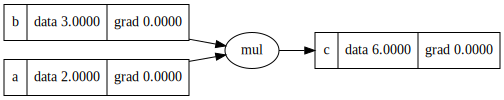

In [4]:
a = Tensor(2, label='a')
b = Tensor(3, label='b')

c = a * b; c.label = 'c'
draw_dot(c)

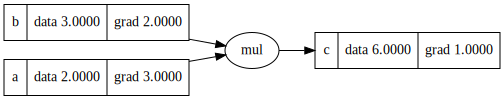

In [5]:
c.backward()

draw_dot(c)

## Adding Activation Functions with Class F

Non-linear activation functions are a core component in neural networks. In our mini PyTorch project, I’ve implemented the hyperbolic tangent (tanh) function inside a helper class `F`.

### `F.tanh(x)`:
- **Input:**  
  The function expects a `Tensor` as input.
  
- **Forward Pass:**  
  It computes the tanh of the tensor’s data using Python’s `math.tanh`, and wraps the result in a new `Tensor`.  
  - The new tensor records the original tensor as its parent and labels the operation as `"tanh"`.
  
- **Backward Pass:**  
  The derivative of tanh, given by \(1 - \tanh(x)^2\), is used to correctly propagate gradients back to the input tensor.
  
This activation function enriches our mini PyTorch by enabling non-linear transformations, which are vital for building complex and powerful neural network models.


In [6]:
class F:
    @staticmethod
    def tanh(x):
        if isinstance(x, Tensor):
            result_data = Tensor(math.tanh(x.data), parents=[x], creation_op="tanh")

            def backward():
                x.grad = (1 - math.tanh(x.data) ** 2) * result_data.grad

            result_data._backward = backward

            return result_data

## Implementing a Simple Neuron in Our Mini PyTorch

Now that we have our `Tensor` class and activation functions, let’s build a fundamental component of neural networks: a **Neuron**. In this mini PyTorch project, a neuron is a simple unit that takes multiple inputs, applies weights and a bias, and passes the result through an activation function.

### `Neuron(input_size)`
- **Weights & Bias:**  
  - Each neuron has a list of weights (`self.weights`), initialized randomly between -1 and 1.
  - A bias term (`self.bias`) is also initialized randomly.
  - Both weights and bias are `Tensor` objects, meaning they support automatic differentiation.

### `forward(x)`
- **Computes the Neuron’s Output:**  
  - The neuron first starts with the bias term.
  - Each input (`x_i`) is multiplied by its corresponding weight (`w_i`), and the results are summed.
  - The sum is then passed through the **tanh activation function** for non-linearity.

### `__call__(x)`
- **Shortcut for Forward Pass:**  
  - This makes the neuron callable like a function: `neuron(x)` instead of `neuron.forward(x)`, improving code readability.

### `parameters()`
- **Returns Learnable Parameters:**  
  - This method gathers all tunable parameters (weights and bias), making it easy to update them during training.

This `Neuron` class is a foundational building block for constructing larger models like fully connected layers and neural networks. Next, we can stack multiple neurons together to form more complex architectures!


In [8]:
class Neuron:
    def __init__(self, input_size):
        self.weights = [Tensor(random.uniform(-1, 1)) for _ in range(input_size)]
        self.bias = Tensor(random.uniform(-1, 1))
    def forward(self, x):
        res = self.bias
        for w_i, x_i in zip(self.weights, x):
            res += w_i * x_i
        return F.tanh(res)

    def __call__(self, x):
        return self.forward(x)
    def parameters(self):
        return self.weights + [self.bias]

## Implementing a Neural Network Layer in Our Mini PyTorch

Now that we have a single `Neuron` class, the next step is to group multiple neurons together into a **Layer**. This class represents a fully connected (dense) layer, where each neuron receives the same set of inputs but has its own unique weights and bias.

### `Layer(input_size, output_size)`
- **Creates `output_size` neurons:**  
  - Each neuron in the layer takes `input_size` inputs.
  - The layer is simply a list of `Neuron` objects.

### `forward(x)`
- **Computes the Layer’s Output:**  
  - It calls each neuron with the same input `x` and collects their outputs into a list.
  - If the layer has only one neuron, it returns a single value instead of a list.

### `__call__(x)`
- **Shortcut for Forward Pass:**  
  - Enables calling the layer like a function: `layer(x)` instead of `layer.forward(x)`, improving readability.

### `parameters()`
- **Gathers All Learnable Parameters:**  
  - Loops through all neurons and collects their weights and biases.
  - This makes it easy to access all the parameters for optimization during training.

This `Layer` class allows us to build deep networks by stacking multiple layers on top of each other. The next step is to combine layers into a full **Neural Network model**!


In [9]:
class Layer:
    def __init__(self, input_size, output_size):
        self.neurons = [Neuron(input_size) for _ in range(output_size)]
    def forward(self, x):
        res = [neuron(x) for neuron in self.neurons]
        return res[0] if len(res) == 1 else res
    def __call__(self, x):
        return self.forward(x)
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params += neuron.parameters()
        return params

## Building a Multi-Layer Perceptron (MLP)

Taking our project a step further, I've put together a simple Multi-Layer Perceptron (MLP) class that builds on our `Layer` class. An MLP is essentially a stack of layers that processes inputs through a series of transformations to produce outputs.

### `MLP(input_size, layer_sizes)`
- **Initialization:**  
  - The constructor takes the input size and a list of layer sizes.  
  - It automatically creates the architecture by constructing layers where the number of neurons in each layer is specified by `layer_sizes`.
  - The total configuration starts with the input size, followed by each layer's size, defining how data flows from one layer to the next.

### `forward(x)`
- **Forward Pass:**  
  - The input `x` is sequentially passed through each layer in the network.
  - Each layer transforms the data, and the output of one layer becomes the input to the next.
  - The final output is returned, representing the network's prediction or transformation.

### `__call__(x)`
- **Convenience:**  
  - This makes the MLP callable like a function, so you can simply write `mlp(x)` to perform a forward pass.

### `parameters()`
- **Collecting Parameters:**  
  - This method aggregates all learnable parameters (weights and biases) from every layer in the network.
  - It's useful for tasks like updating weights during training using optimization algorithms.

This `MLP` class encapsulates the essence of a neural network, allowing us to build and experiment with different architectures in our mini PyTorch project. It demonstrates how simple components can be combined to create complex models, much like in full-fledged deep learning frameworks.


In [10]:
class MLP:
    def __init__(self, input_size, layer_sizes):
        layer_total = [input_size] + layer_sizes
        self.layers = [Layer(layer_total[i], layer_total[i + 1]) for i in range(len(layer_sizes))]
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def __call__(self, x):
        return self.forward(x)
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters()
        return params

## Implementing a Basic Optimizer

In our mini PyTorch project, we've built a simple optimizer class that mimics the behavior of standard gradient descent. This class is responsible for updating the parameters of our neural network based on their gradients.

### `Optimizer(parameters, lr)`
- **Parameters:**  
  - The optimizer takes a list of parameters (learnable weights and biases) from our model.
  - It also takes a learning rate (`lr`) which controls the size of the updates during training.

### Methods:
- **`zero_grad()`**  
  - Resets the gradients of all parameters to zero.  
  - This is crucial before each new iteration of training to ensure that gradients are not accumulated from previous iterations.

- **`step()`**  
  - Updates each parameter by subtracting the product of its gradient and the learning rate.  
  - This is the essence of the gradient descent update rule.

This basic optimizer is a foundational tool for training our model. By repeatedly applying `zero_grad()` and `step()` during training, we can iteratively minimize the loss function and improve the model's performance.


In [11]:
class Optimizer:

    def __init__(self, parameters, lr):
        self.parameters = parameters
        self.lr = lr

    def zero_grad(self):
        for param in self.parameters:
            param.zero_grad()

    def step(self):
        for param in self.parameters:
            param.data -= param.grad * self.lr

## Helper functions



## Making Predictions with Our Model

The `make_predictions` function serves as a simple interface to obtain predictions from our mini PyTorch model on a dataset.

### `make_predictions(model, X)`
- **Purpose:**  
  - Iterates through each example in the input dataset `X` and generates predictions using the provided `model`.

- **How It Works:**  
  - For each input `x` in `X`, the function calls the model (using its `__call__` method) to compute the prediction.
  - It collects all the predictions in a list and returns this list.

This function streamlines the process of generating outputs from the model, making it easy to evaluate and work with predictions on a batch of data.


In [24]:
def make_predictions(model, X):
    preds = []
    for x in X:
        pred = model(x)
        preds.append(pred)
    return preds

## Defining the Loss Function

To train our mini PyTorch model, we need a way to quantify how far our predictions are from the true values. Here, I’ve implemented a simple mean squared error (MSE) loss function.

### `calculate_loss(y_true, y_pred)`
- **Purpose:**  
  - Computes the mean squared error between the predicted outputs (`y_pred`) and the actual targets (`y_true`).

- **How It Works:**  
  - Initializes the loss as a `Tensor` with value 0.
  - Iterates over pairs of true and predicted values, computing the squared difference for each pair.
  - Accumulates these squared differences into the loss.
  - Finally, divides the total loss by the number of examples to compute the average loss.

This function is essential for measuring the performance of our model and guiding the optimization process during training.


In [25]:
def calculate_loss(y_true, y_pred):

    loss = Tensor(0)

    for y_t, y_p in zip(y_true, y_pred):
        loss += (y_p - y_t) ** 2

    return loss / len(y_true)

## Test and Results

### Preprocessing

we test our simple mini pyTourch by making a MLP and run a classification task on Iris dataset

In [26]:
df = pd.read_csv("./iris.csv")
df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In this step we run a label encoding to make our dataset feedable to our neural network

In [27]:
variety_encoding = {"Setosa":1,"Versicolor":2,"Virginica":3}
df["variety"] = df["variety"].apply(variety_encoding.get)
df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,3
146,6.3,2.5,5.0,1.9,3
147,6.5,3.0,5.2,2.0,3
148,6.2,3.4,5.4,2.3,3


Now we run a minmax scaler to make our data range more standard to get better results

In [28]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_df = min_max_scaler.fit_transform(df)
new_df = pd.DataFrame(min_max_df)
new_df

,0,1,2,3,4
0,0.222222,0.625000,0.067797,0.041667,0.0
1,0.166667,0.416667,0.067797,0.041667,0.0
2,0.111111,0.500000,0.050847,0.041667,0.0
3,0.083333,0.458333,0.084746,0.041667,0.0
4,0.194444,0.666667,0.067797,0.041667,0.0
...,...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667,1.0
146,0.555556,0.208333,0.677966,0.750000,1.0
147,0.611111,0.416667,0.711864,0.791667,1.0
148,0.527778,0.583333,0.745763,0.916667,1.0


## Spliting Test and Train

In [29]:
y = new_df[4]
X = new_df.drop(4, axis=1)
X = X.to_numpy()
y = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

## Declaring our desired MLP

In [42]:
input_size = 4 # Number of features in the input layer
layer_sizes = [3, 4, 4 ,1] # Number of neurons in each hidden and output layer

model = MLP(input_size, layer_sizes)

params = model.parameters()

optim = Optimizer(params, 0.15)

## Performing Training

In [43]:
n_epochs = 1000


for i in range(n_epochs):

    y_hats = make_predictions(model, X_train)

    loss = calculate_loss(y_train, y_hats)

    print(f"loss in iteration{i}: {loss}")

    optim.zero_grad()

    loss.backward()

    optim.step()

loss in iteration0: Tensor(data=1.42938659449927, grad=0.0)
loss in iteration1: Tensor(data=1.427120345375033, grad=0.0)
loss in iteration2: Tensor(data=1.4248446237129384, grad=0.0)
loss in iteration3: Tensor(data=1.4225593828600254, grad=0.0)
loss in iteration4: Tensor(data=1.4202645760270947, grad=0.0)
loss in iteration5: Tensor(data=1.417960156291646, grad=0.0)
loss in iteration6: Tensor(data=1.4156460766009087, grad=0.0)
loss in iteration7: Tensor(data=1.4133222897749853, grad=0.0)
loss in iteration8: Tensor(data=1.4109887485101151, grad=0.0)
loss in iteration9: Tensor(data=1.408645405382044, grad=0.0)
loss in iteration10: Tensor(data=1.4062922128495134, grad=0.0)
loss in iteration11: Tensor(data=1.4039291232578728, grad=0.0)
loss in iteration12: Tensor(data=1.4015560888428196, grad=0.0)
loss in iteration13: Tensor(data=1.3991730617342533, grad=0.0)
loss in iteration14: Tensor(data=1.3967799939602688, grad=0.0)
loss in iteration15: Tensor(data=1.394376837451282, grad=0.0)
loss in 

In [44]:
t_arr = []
for i in range(len(X_test)):
    output = model(X_test[i])
    t_arr.append(output)
    print(output, " label: ",y_test[i])

Tensor(data=0.427579910573807, grad=0.0)  label:  0.5
Tensor(data=0.29344108648963274, grad=0.0)  label:  0.0
Tensor(data=0.45440188753641486, grad=0.0)  label:  1.0
Tensor(data=0.40575142674573095, grad=0.0)  label:  0.5
Tensor(data=0.447446477318138, grad=0.0)  label:  0.5
Tensor(data=0.27887580810822904, grad=0.0)  label:  0.0
Tensor(data=0.37079684657592804, grad=0.0)  label:  0.5
Tensor(data=0.41982535453717734, grad=0.0)  label:  1.0
Tensor(data=0.442931835425493, grad=0.0)  label:  0.5
Tensor(data=0.40797976037188216, grad=0.0)  label:  0.5
Tensor(data=0.4094148310989484, grad=0.0)  label:  1.0
Tensor(data=0.25290233609094454, grad=0.0)  label:  0.0
Tensor(data=0.2931286373051527, grad=0.0)  label:  0.0
Tensor(data=0.2625155699652565, grad=0.0)  label:  0.0
Tensor(data=0.1438984244418655, grad=0.0)  label:  0.0
Tensor(data=0.4029140247874346, grad=0.0)  label:  0.5
Tensor(data=0.41762396797458423, grad=0.0)  label:  1.0
Tensor(data=0.4111826622693922, grad=0.0)  label:  0.5
Tens

### Preforming predictions

In [45]:
y_pred = []
for t in t_arr:
    y_pred.append(t.data)
y_pred = np.array(y_pred)
y_pred

array([0.42757991, 0.29344109, 0.45440189, 0.40575143, 0.44744648,
       0.27887581, 0.37079685, 0.41982535, 0.44293184, 0.40797976,
       0.40941483, 0.25290234, 0.29312864, 0.26251557, 0.14389842,
       0.40291402, 0.41762397, 0.41118266, 0.40110644, 0.41823697,
       0.18810146, 0.40211281, 0.19704871, 0.4205411 , 0.44130542,
       0.41688046, 0.4455688 , 0.42040257, 0.22644745, 0.23348601])

### Evaluation with r2 score

In [46]:
r2_score(y_test, y_pred)

0.17865661907655495